### Text to speech using torch audio

In this notebook we are going to illustrate how to build a text to speech pipeline using `Tacotron2` in `torchaudio`.

We are going to follow the following steps:


1.  Text preprocessing

* First, the input text is encoded into a list of symbols. In this tutorial, we will use English characters and phonemes as the symbols.

2. Spectrogram generation

* From the encoded text, a spectrogram is generated. We use ``Tacotron2`` model for this.

3. Time-domain conversion

* The last step is converting the spectrogram into the waveform. The process to generate speech from spectrogram is also called Vocoder. In this notebook we are going to use three different vocoders which are
  * [`WaveRNN`](https://pytorch.org/audio/stable/models/wavernn.html)
  * [`Griffin-Lim`](https://pytorch.org/audio/stable/transforms.html#griffinlim)
  * [`Nvidia's WaveGlo`](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/)



The process is shown in the following image.

![img](https://download.pytorch.org/torchaudio/tutorial-assets/tacotron2_tts_pipeline.png)


### Installation

We need to install `torchaudio` and `DeepPhonemizer` as follows:



In [2]:
!pip install torchaudio

     |████████████████████████████████| 881.9 MB 20 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.10.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.10.0 which is incompatible.


In [3]:
!pip install -q deep_phonemizer

     |████████████████████████████████| 596 kB 6.2 MB/s 


### Imports

We need to inport all the packages that we are going to use in the following cell: 


In [4]:
import torch, torchaudio, IPython
import matplotlib.pyplot as plt


print("torch version: ", torch.__version__)
print("torchaudio version: ", torchaudio.__version__)

torch version:  1.10.0+cu102
torchaudio version:  0.10.0+cu102


### Device and seed

In [5]:
SEED = 42

torch.random.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Text Processing


### Character based encoding
We will go through how the character-based encoding works.

Since the pre-trained Tacotron2 model expects specific set of symbol tables, the same functionalities available in ``torchaudio``. This section is more for the explanation of the basis of encoding.

Firstly, we define the set of symbols. For example, we can use `'_-!\'(),.:;?` `abcdefghijklmnopqrstuvwxyz`'. Then, we will map the each character of the input text into the index of the corresponding symbol in the table.

In [6]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s:i for i, s in enumerate(symbols)}
symbols = set(symbols)

In [7]:
look_up

{' ': 11,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 1,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 '_': 0,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

The text to sequence funtion converts text into sequence of integers.

In [8]:
def text_to_sequence(text: str)->list:
  text = text.lower()
  return [look_up[s] for s in text if s in symbols] # we ignore characters that are not in the symbols that we have defined


In [9]:
text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


As mentioned in the above, the symbol table and indices must match what the pretrained ``Tacotron2`` model expects. ``torchaudio`` provides the transform along with the pretrained model. For example, you can instantiate and use such transform as follow.

In [12]:
processor = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

assert len(text) == lengths.item(), "miss match of length"


tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


The ``processor`` object takes either a text or list of texts as inputs. When a list of texts are provided, the returned lengths variable represents the valid length of each processed tokens in the output batch.

In [15]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it uses a symbol table based on phonemes and a ``G2P`` (Grapheme-to-Phoneme) model.

Similar to the case of character-based encoding, the encoding process is expected to match what a pretrained ``Tacotron2`` model is trained on. ``torchaudio`` has an interface to create the process.


> The following code illustrates how to make and use the process. Behind the scene, a ``G2P`` model is created using ``DeepPhonemizer`` package, and the pretrained weights published by the author of ``DeepPhonemizer`` is fetched.



In [17]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
  processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


Notice that the encoded values are different from the example of character-based encoding.

The intermediate representation looks like the following.

In [18]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


### Spectrogram Generation

Tacotron2 is the model we use to generate spectrogram from the encoded text. For more info refer to [this](https://arxiv.org/abs/1712.05884).

``torchaudio`` bundles the matching models and processors together so that it is easy to create the pipeline, for more bundles [read the docs](https://pytorch.org/audio/stable/pipelines.html#tacotron2-text-to-speech)


In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

In [20]:
text = "Hello world! Text to speech!"

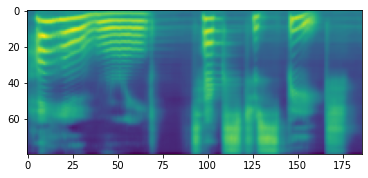

In [23]:
with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, _, __ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())
plt.show()

Note that ``Tacotron2.infer`` method perfoms multinomial sampling, therefore, the process of generating the spectrogram incurs randomness.

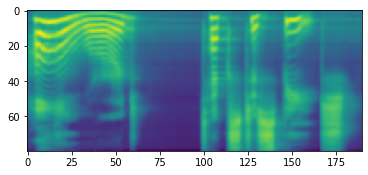

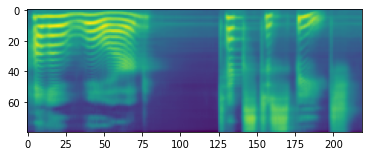

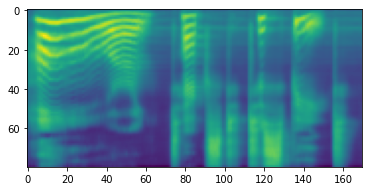

In [28]:
for _ in range(3):
  with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  plt.imshow(spec[0].cpu().detach())
  plt.show()

### Waveform Generation

* Once the ``spectrogram`` is generated, the last process is to recover the ``waveform`` from the ``spectrogram``.

``torchaudio`` provides vocoders based on ``GriffinLim`` and ``WaveRNN``


### WaveRNN
We can instantiate the matching WaveRNN model from the same bundle.

In [29]:
vocoder = bundle.get_vocoder().to(device)
text = "Hello world! Text to speech!"


with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)
torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)


Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

In [30]:
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

In [31]:
with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernn1.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

### Griffin-Lim

Using the ``Griffin-Lim`` vocoder is same as ``WaveRNN``. We can instantiate the vocode object with ``get_vocoder`` method and pass the spectrogram.

In [32]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_griffinlim.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_griffinlim.wav"))

### Waveglow

Waveglow is a vocoder published by Nvidia. The pretrained weight is publishe on Torch Hub. One can instantiate the model using ``torch.hub`` module.

In [33]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
  waveforms = waveglow.infer(spec)

torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.display(IPython.display.Audio("output_waveglow.wav"))


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]


In [34]:
torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.display(IPython.display.Audio("output_waveglow.wav"))

### The function that takes text and convert it to audios.

In [48]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

def speech_2_audio(text):
  with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  with torch.no_grad():
    waveforms = waveglow.infer(spec)

  torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
  IPython.display.display(IPython.display.Audio("output_waveglow.wav"))

speech_2_audio("hello world!")

In [49]:
speech_2_audio("hello world, how are you doing programmers!")

### Conlusion
 We have learnt to convert text to speech using `TACOTRON2`, here is the  conclusion for each vocoder.

1. WaveRNN
* good audio quality with but takes time to encode.

2.  Griffin-Lim
* poor audio quality and takes long to encode.

3. Nvidia's WaveGlow
* it is fast and deliver good quality as compared to others.